## Import All libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, split, posexplode, udf, explode
from pyspark.sql.types import ArrayType, DoubleType, StringType
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import Word2Vec, StandardScaler
from pyspark.ml.feature import PCA

## Read the Csv file

In [ ]:
# Create Spark session
spark = SparkSession.builder.appName("Clustering-Task").getOrCreate()


# Define path
path = '.\Engineering\Clustering-Data.csv'

# create spark dataframe
df = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .option("multiLine", True) \
    .option("quote", '"') \
    .option("escape", '"') \
    .option("mode", "PERMISSIVE") \
    .csv(path)


df.show()

+----------------+-------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        filename|    cik|year|           section_1|          section_1A|          section_1B|           section_2|           section_3|           section_4|           section_5|           section_6|           section_7|          section_7A|           section_8|           section_9|          section_9A|          section_9B|          section_10|          section_11|          section_12|          section_13|          section_14|          section_15|
+----------------+-------+----+--------------------+--------------------+--------------------+--

## Unpivoted version of Orginal DataFrame -  where each row represents one section of a 10-K document.



In [ ]:
# Define section columns from section_1 to section_15 (including 9A, 9B)
section_cols = [f"section_{i}" if i not in ['9A', '9B'] else f"section_{i}" for i in list(range(1, 9)) + ['9A', '9B'] + list(range(10, 16))]

# Explode sections into separate rows with section name and text
df_melted = df.select(
    col("filename"),
    col("cik"),
    col("year"),
    F.explode(F.array([
        F.struct(F.lit(c).alias("section_name"), col(c).alias("text")) for c in section_cols
    ])).alias("exploded")
).select(
    "filename", "cik", "year", "exploded.section_name", "exploded.text"
)
df_melted.show()

+---------------+------+----+------------+--------------------+
|       filename|   cik|year|section_name|                text|
+---------------+------+----+------------+--------------------+
|718413_2020.htm|718413|2020|   section_1|Item 1. The Busin...|
|718413_2020.htm|718413|2020|   section_2|Item 2. Propertie...|
|718413_2020.htm|718413|2020|   section_3|Item 3. Legal Pro...|
|718413_2020.htm|718413|2020|   section_4|Item 4. Mine Safe...|
|718413_2020.htm|718413|2020|   section_5|Item 5. Market fo...|
|718413_2020.htm|718413|2020|   section_6|Item 6. Selected ...|
|718413_2020.htm|718413|2020|   section_7|Item 7. Managemen...|
|718413_2020.htm|718413|2020|   section_8|Item 8. Financial...|
|718413_2020.htm|718413|2020|  section_9A|Item 9A. Controls...|
|718413_2020.htm|718413|2020|  section_9B|Item 9B. Other In...|
|718413_2020.htm|718413|2020|  section_10|Item 10. Director...|
|718413_2020.htm|718413|2020|  section_11|Item 11. Executiv...|
|718413_2020.htm|718413|2020|  section_1

## Check Shape Of DataFrame

In [ ]:
# Number of rows
num_rows = df_melted.count()

# Number of columns
num_cols = len(df_melted.columns)

print(f"Shape: ({num_rows}, {num_cols})")

Shape: (160, 5)


## Filter Out all Null Values
* No Null Values in dataset since the shape is same

In [ ]:
df_melted = df_melted.filter(F.col("text").isNotNull())
# Number of rows
num_rows = df_melted.count()

# Number of columns
num_cols = len(df_melted.columns)

print(f"Shape: ({num_rows}, {num_cols})")

Shape: (160, 5)


## Implementing Chunking  text column consisting of section data

In [ ]:
#  Define UDF to chunk list of words into 500-word chunks
def chunk_words(words, chunk_size=500):
    return [' '.join(words[i:i+chunk_size]) for i in range(0, len(words), chunk_size)]

chunk_words_udf = udf(chunk_words, ArrayType(StringType()))

# Tokenize text
df_tokenized = df_melted.withColumn("words", split(col("text"), " "))

# Create chunks from words
df_chunked = df_tokenized.withColumn("chunks", chunk_words_udf(col("words")))

df_final = df_chunked.select(
    "filename", "cik", "year", "section_name",
    posexplode("chunks").alias("chunk_index", "chunk_text")
)

df_final.show()

+---------------+------+----+------------+-----------+--------------------+
|       filename|   cik|year|section_name|chunk_index|          chunk_text|
+---------------+------+----+------------+-----------+--------------------+
|718413_2020.htm|718413|2020|   section_1|          0|Item 1. The Busin...|
|718413_2020.htm|718413|2020|   section_1|          1|not eligible for ...|
|718413_2020.htm|718413|2020|   section_1|          2|the market areas ...|
|718413_2020.htm|718413|2020|   section_1|          3|from federal inco...|
|718413_2020.htm|718413|2020|   section_1|          4|approval is also ...|
|718413_2020.htm|718413|2020|   section_1|          5|and CFSG are all ...|
|718413_2020.htm|718413|2020|   section_1|          6|of much of this t...|
|718413_2020.htm|718413|2020|   section_1|          7|as noted in Note ...|
|718413_2020.htm|718413|2020|   section_1|          8|disclosures in it...|
|718413_2020.htm|718413|2020|   section_1|          9|subsequent regula...|
|718413_2020

## Implementing Word2Vec Embedding

In [ ]:
# Split chunk text into words
df_final_chunks = df_final.withColumn("chunk_words", split(col("chunk_text"), " "))

# Create 'words' column for Word2Vec input
wordsData = df_final_chunks.withColumn("words", split(col("chunk_text"), " "))

# Initialize Word2Vec model
word2vec = Word2Vec(vectorSize=100, minCount=1, inputCol="words", outputCol="features")


# Fit and transform the model on words data
model = word2vec.fit(wordsData)
result = model.transform(wordsData)

In [ ]:
# View the result
result.select("filename", "section_name", "chunk_index", "chunk_text", "features").show(truncate=False)

+---------------+------------+-----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Standard Scaling Of Features

In [ ]:
# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(result)
scaled_result = scaler_model.transform(result)

## Implementing PCA On dataset

In [ ]:
# Reduce to, say, 50 dimensions
pca = PCA(k=50, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_result)
pca_result = pca_model.transform(scaled_result)

## Visualising PCA visualisation

In [ ]:
# Further reduce to 2D for visualization
pca_2d = PCA(k=2, inputCol="scaled_features", outputCol="viz_2d")
pca_2d_model = pca_2d.fit(scaled_result)
viz_result = pca_2d_model.transform(scaled_result)

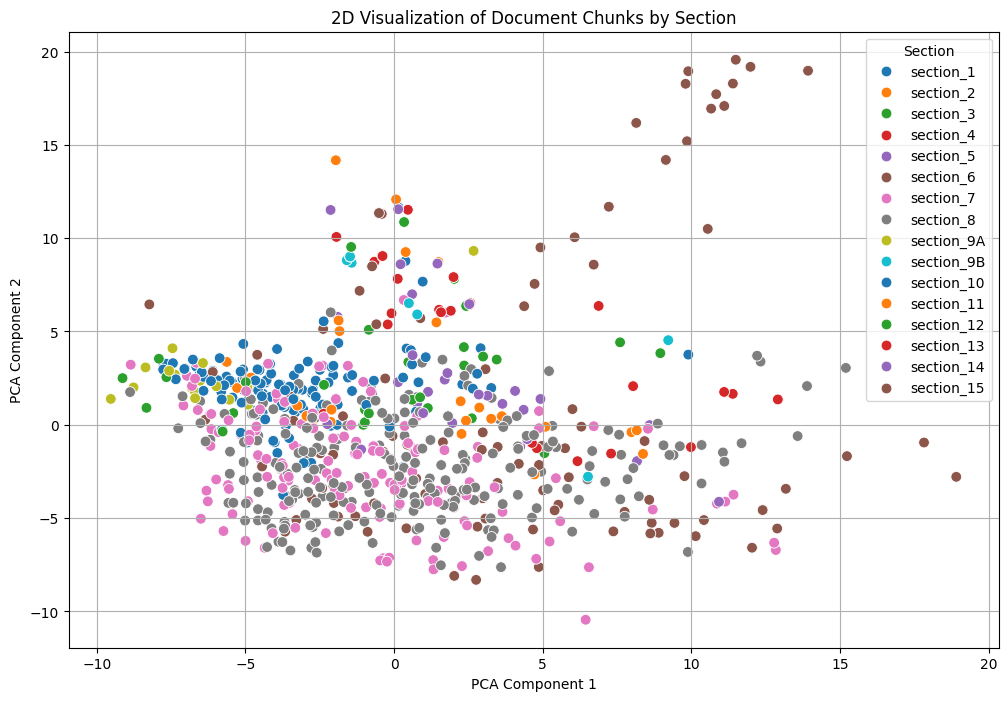

In [ ]:
# Only bring what you need to avoid memory issues
plot_df = viz_result.select("filename", "section_name", "chunk_index", "viz_2d").toPandas()
# Convert DenseVector to two float columns
plot_df[["x", "y"]] = plot_df["viz_2d"].apply(lambda vec: pd.Series([vec[0], vec[1]]))

# plot figure
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x="x", y="y", hue="section_name", palette="tab10", s=60)

plt.title("2D Visualization of Document Chunks by Section")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Section")
plt.grid(True)
plt.show()

## Implementing Kmeans Cluster

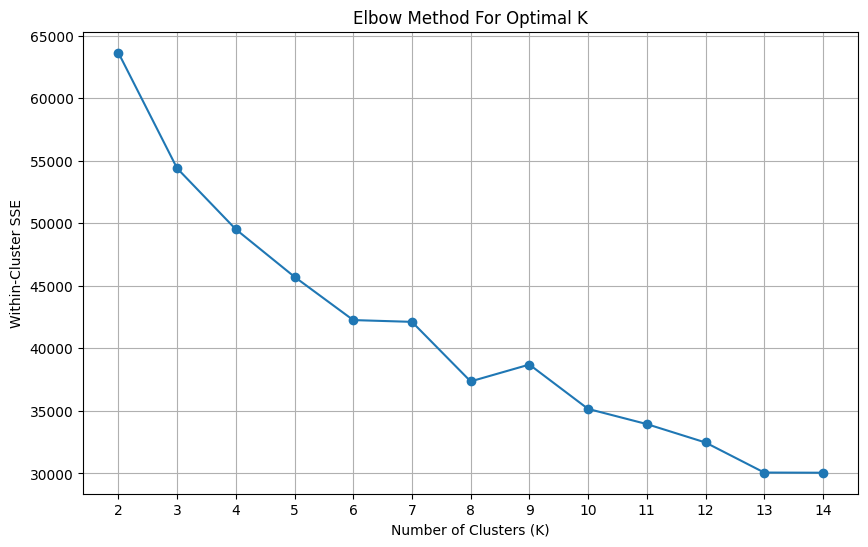

In [ ]:
# Try different values of K
costs = []
K_range = list(range(2, 15))

for k in K_range:
    kmeans = KMeans(featuresCol="pca_features", k=k, seed=42)
    model = kmeans.fit(pca_result)
    cost = model.summary.trainingCost  # SSE (sum of squared distances to centroids)
    costs.append(cost)
plt.figure(figsize=(10, 6))
plt.plot(K_range, costs, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster SSE')
plt.title('Elbow Method For Optimal K')
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [ ]:
# Apply KMeans to 50D PCA features
kmeans = KMeans(featuresCol="pca_features", predictionCol="cluster", k=8, seed=42)
kmeans_model = kmeans.fit(pca_result)
clustered_result = kmeans_model.transform(pca_result)

In [ ]:
# Get centroids
centroids = kmeans_model.clusterCenters()

# UDF to calculate distance from centroid
def compute_distance(vec, cluster_id):
    center = np.array(centroids[cluster_id])
    return float(np.linalg.norm(np.array(vec) - center))

distance_udf = udf(compute_distance, DoubleType())

# Add distance column
clustered_result = clustered_result.withColumn("distance_from_centroid", distance_udf(col("pca_features"), col("cluster")))

# Flag top 5% as outliers
quantile_value = clustered_result.approxQuantile("distance_from_centroid", [0.95], 0.0)[0]
clustered_result = clustered_result.withColumn("is_outlier", (col("distance_from_centroid") > quantile_value).cast("int"))

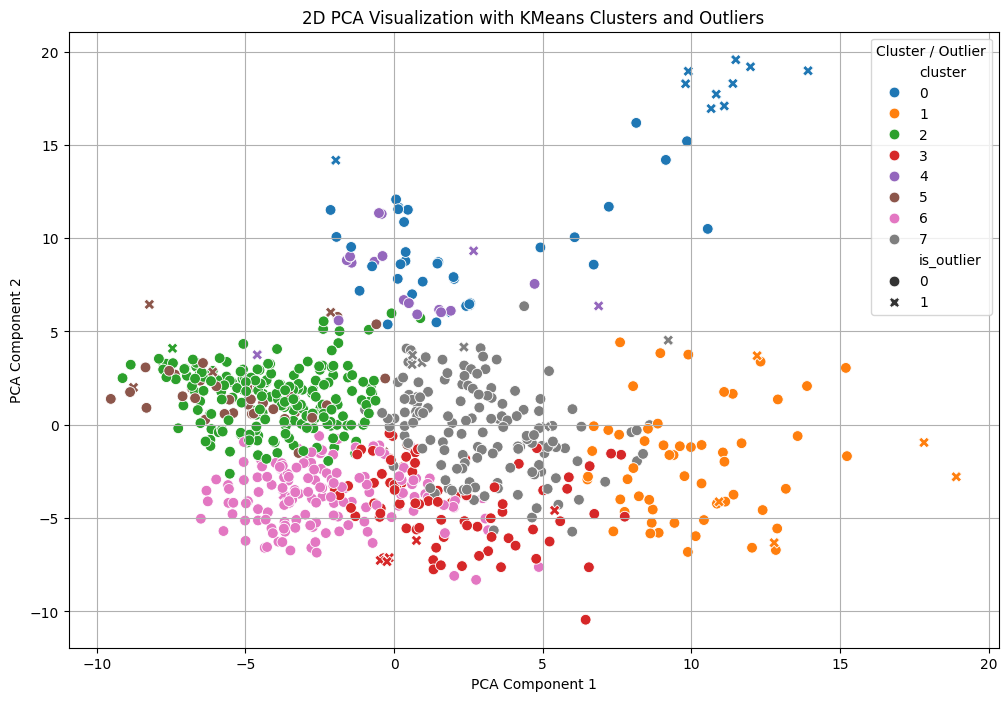

In [ ]:
# Apply PCA to reduce from 50D to 2D
pca_2d = PCA(k=2, inputCol="scaled_features", outputCol="viz_2d")
pca_2d_model = pca_2d.fit(clustered_result)
viz_result = pca_2d_model.transform(clustered_result)

plot_df = viz_result.select("viz_2d", "cluster", "is_outlier", "section_name").toPandas()

# Split vector into x, y
plot_df[["x", "y"]] = plot_df["viz_2d"].apply(lambda vec: pd.Series([vec[0], vec[1]]))

# Plot figure
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=plot_df,
    x="x", y="y",
    hue="cluster",
    style="is_outlier",
    palette="tab10",
    markers={0: "o", 1: "X"},
    s=60
)
plt.title("2D PCA Visualization with KMeans Clusters and Outliers")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster / Outlier")
plt.grid(True)
plt.show()